## 1. Instalação e Setup

In [1]:
# Instalação da biblioteca Ultralytics
!pip install ultralytics
!pip install opencv-python matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importação das bibliotecas necessárias
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 2. Carregando um modelo pré-treinado

In [3]:
# Carregando o modelo YOLOv8n (nano - versão mais leve)
model = YOLO('yolov8l.pt')

# Também podemos carregar diferentes tamanhos de modelo:
# model = YOLO('yolov8s.pt')  # small
# model = YOLO('yolov8m.pt')  # medium
# model = YOLO('yolov8l.pt')  # large
# model = YOLO('yolov8x.pt')  # extra large

100%|██████████| 83.7M/83.7M [00:16<00:00, 5.17MB/s]


## 3. Função auxiliar para visualização

In [17]:
def visualize_detection(image, results):
    """
    Visualiza a imagem com as detecções.
    """
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(results[0].plot())
    plt.axis('off')
    plt.show()

    boxes = results[0].boxes
    print(f"Foram detectados {len(boxes)} objetos")

    for i, box in enumerate(boxes):
        cls = int(box.cls[0])
        name = model.names[cls]
        conf = float(box.conf[0])
        print(f"Detecção {i+1}: {name} com confiança {conf:.2f}")


## 4. Baixar imagem de teste


In [30]:
def baixar_arquivo(url, destino):
    try:
        if os.path.exists(destino):
            print(f"Arquivo já existe: {destino}")
            return True

        resposta = requests.get(url, timeout=10)
        resposta.raise_for_status()

        with open(destino, "wb") as f:
            f.write(resposta.content)

        print(f"Download concluído: {destino}")
        return True
    except Exception as e:
        print(f"Erro ao baixar o arquivo: {e}")
        return False

# Exemplo de imagem com moto (pode trocar por outra imagem depois)
url = "https://ultralytics.com/images/bus.jpg"
destino = "gatoGordo.jpeg"
baixar_arquivo(url, destino)


Erro ao baixar o arquivo: name 'os' is not defined


False

## 5. Inferência padrão na imagem



image 1/1 c:\Users\luizf\Downloads\ProjetoMottuYoloVC\gatoGordo.jpeg: 384x640 1 cat, 945.5ms
Speed: 4.9ms preprocess, 945.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


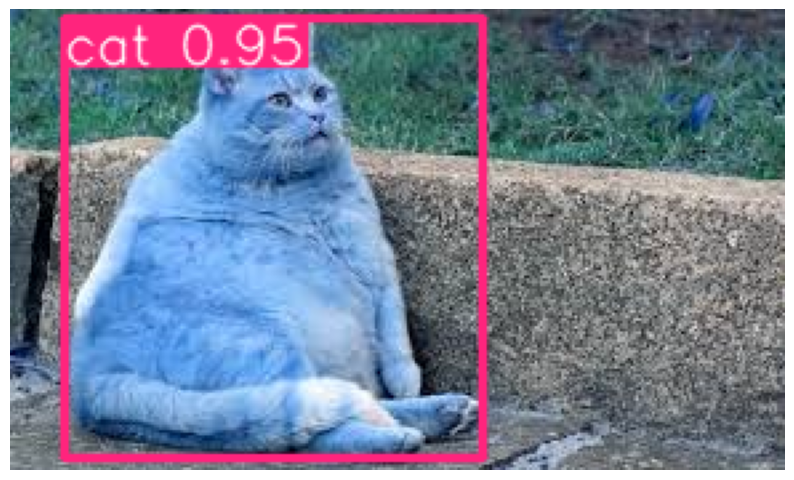

Foram detectados 1 objetos
Detecção 1: cat com confiança 0.95


In [31]:
# Detecção com todos os objetos
results = model('gatoGordo.jpeg')

# Visualizar os resultados
visualize_detection('gatoGordo.jpeg', results)


## 6. Explorar resultados

In [25]:
result = results[0] 

print("Bounding boxes:")
print(result.boxes.xyxy)

print("\nClasses detectadas:")
print(result.boxes.cls)

print("\nNomes das classes:")
for c in result.boxes.cls:
    print(model.names[int(c)])

print("\nScores de confiança:")
print(result.boxes.conf)


Bounding boxes:
tensor([], size=(0, 4))

Classes detectadas:
tensor([])

Nomes das classes:

Scores de confiança:
tensor([])


## 7. Detecção em vídeo

In [29]:
# Processar vídeo local (substituir o nome se necessário)
results_video = model('videoGato.mp4', save=True)

# O vídeo será salvo em 'runs/detect/predict/'



WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/468) c:\Users\luizf\Downloads\ProjetoMottuYoloVC\videoGato.mp4: 640x640 2 cats, 1453.3ms
video 1/1 (frame 2/468) c:\Users\luizf\Downloads\ProjetoMottuYoloVC\videoGato.mp4: 640x640 2 cats, 1419.6ms
video 1/1 (frame 3/468) c:\Users\luizf\Downloads\ProjetoMottuYoloVC\videoGato.mp4: 640x640 2 cats, 1334.9ms
video 1/1 (frame 4/468) c:\Users\luizf\Downloads\ProjetoMottuYoloVC\videoGato.mp4: 640x640 2 cats, 1698.3ms
video 1/1 (frame 5/468) c:\

 ## 8. Detecção com filtro — Apenas Motos


image 1/1 c:\Users\luizf\Downloads\ProjetoMottuYoloVC\variosGatos.jpg: 384x640 2 cats, 594.5ms
Speed: 3.2ms preprocess, 594.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


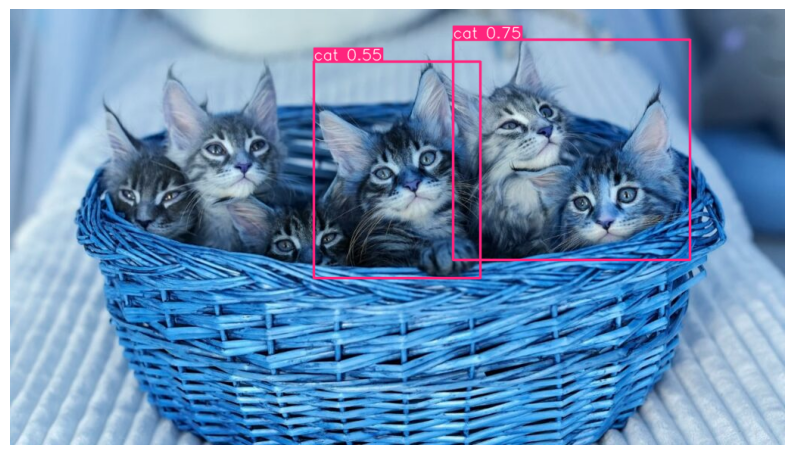

Foram detectados 2 objetos
Detecção 1: cat com confiança 0.75
Detecção 2: cat com confiança 0.55


In [ ]:
# Apenas classe 3 = 'motorcycle' será detectada
results_motos = model(
    'variosGatos.jpg',
    conf=0.5,
    iou=0.7,
    max_det=20,
    classes=[3]
)

# Visualizar resultado da detecção apenas de motos
visualize_detection('variosGatos.jpg', results_motos)


##  9. Lista de classes COCO

In [16]:
# Lista de todas as classes que o modelo reconhece
for idx, class_name in model.names.items():
    print(f"{idx}: {class_name}")


0: person
1: bicycle
2: car
3: motorcycle
4: airplane
5: bus
6: train
7: truck
8: boat
9: traffic light
10: fire hydrant
11: stop sign
12: parking meter
13: bench
14: bird
15: cat
16: dog
17: horse
18: sheep
19: cow
20: elephant
21: bear
22: zebra
23: giraffe
24: backpack
25: umbrella
26: handbag
27: tie
28: suitcase
29: frisbee
30: skis
31: snowboard
32: sports ball
33: kite
34: baseball bat
35: baseball glove
36: skateboard
37: surfboard
38: tennis racket
39: bottle
40: wine glass
41: cup
42: fork
43: knife
44: spoon
45: bowl
46: banana
47: apple
48: sandwich
49: orange
50: broccoli
51: carrot
52: hot dog
53: pizza
54: donut
55: cake
56: chair
57: couch
58: potted plant
59: bed
60: dining table
61: toilet
62: tv
63: laptop
64: mouse
65: remote
66: keyboard
67: cell phone
68: microwave
69: oven
70: toaster
71: sink
72: refrigerator
73: book
74: clock
75: vase
76: scissors
77: teddy bear
78: hair drier
79: toothbrush
